# Compute transforms from aspect solution DY/DZ to CHIPX/CHIPY

A key part of the process to apply dynamic ACA offsets to each observation is
computing the required DY/DZ aspect solution value to move the aimpoint to the
specified CHIPX/CHIPY coordinate.  This notebook computes these transforms
for each ACIS and HRC chip.

The final results are used in the `chandra_aca.drift` module.

This notebook was originally based on the `absolute_pointing_uncertainty` notebook
in this repository.

In [1]:
from __future__ import print_function, division

import argparse
import re
import time
from itertools import izip, cycle
import functools
from pprint import pprint

import numpy as np
import Ska.DBI
from astropy.table import Table, vstack
from astropy.time import Time
import mica.archive.obspar
from mica.archive import asp_l1
import Ska.Shell
from Ska.quatutil import yagzag2radec
from Quaternion import Quat
from Ska.quatutil import radec2yagzag
from sherpa import ui

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Sherpa is too chatty so just turn off all logging (attempts to do this more selectively
# did not work on first try)
import logging
logging.disable(50)

In [3]:
# Nominal SIM focus and TSC positions.  This is run once with cell below and values
# are filled in to avoid repeating this exercise.  Originally use:
# sim_x_nom = {}
# sim_z_nom = {}
sim_x_nom = {
     'ACIS-I': -0.78090834371672724,
     'ACIS-S': -0.68282252473119054,
     'HRC-I': -1.0388663562382989,
     'HRC-S': -1.526339935833849}
sim_z_nom = {
     'ACIS-I': -233.58743446082869,
     'ACIS-S': -190.1400660498719,
     'HRC-I': 126.98297998998621,
     'HRC-S': 250.46603308020099}

In [4]:
if not sim_x_nom or not sim_z_nom:
    from Ska.DBI import DBI
    db = DBI(server='sybase', dbi='sybase', user='aca_read')
    dat = db.fetchall('select detector, sim_x, sim_z from obspar where obsid>12000 and obsid<18000')
    for det in ('ACIS-S', 'ACIS-I', 'HRC-S', 'HRC-I'):
        ok = dat['detector'] == det
        sim_x_nom[det] = np.median(dat['sim_x'][ok])
        sim_z_nom[det] = np.median(dat['sim_z'][ok])
    db.conn.close()
    from pprint import pprint
    pprint(sim_x_nom)
    pprint(sim_z_nom)

In [5]:
aimpoint_data_cache = {}
acis_pixscale = 0.492  # arcsec / pixel

def get_aimpoint_data(det):
    """
    Read aimpoint data provided by P. Zhao and define additional columns
    that make it easier to compare with fid light drift data.
    """
    if det not in aimpoint_data_cache:
        filename = 'optics_aimpoint/{}_ap_pos.rdb'.format(re.sub(r'-', '', det).lower())
        dat = Table.read(filename, format='ascii.rdb')
        y_off = dat['y_det_offset'] * 60 / acis_pixscale  # pix / arcmin
        z_off = dat['z_det_offset'] * 60 / acis_pixscale  # pix / arcmin

        aimpoint_data_cache[det] = dat
    return aimpoint_data_cache[det]    

In [6]:
def get_zero_offset_aimpoint_data(det, min_year=2010):
    """
    Return aimpoint data for observations with zero target offset.
    This simplifies the correlation of aspect solution and dmcoords
    results with the published POG plots (chapter 4) of aimpoint drift.
    """
    dat = get_aimpoint_data(det)
    ok = (dat['y_det_offset'] == 0) & (dat['z_det_offset'] == 0) & (dat['year'] > min_year)
    return dat[ok]

In [7]:
dats = get_zero_offset_aimpoint_data('ACIS-S', 2010)
dati = get_zero_offset_aimpoint_data('ACIS-I', 2010)
hrcs = get_zero_offset_aimpoint_data('HRC-S', 2010)
hrci = get_zero_offset_aimpoint_data('HRC-I', 2010)

observations = vstack([dats, dati, hrcs, hrci])

In [8]:
# Use the obspar for each obsid to fill in some additional
# columns.  Yag and Zag represent the local frame position
# (arcsec) of the target in the nominal frame.

noms = ('ra_nom', 'dec_nom', 'roll_nom')
for nom in noms:
    observations[nom] = 0.0
observations['yag'] = 0.0
observations['zag'] = 0.0
observations['ra_pnt'] = 0.0
observations['dec_pnt'] = 0.0
observations['detector'] = 'ACIS-S'

for obs in observations:
    obspar = mica.archive.obspar.get_obspar(obs['obsid'])
    for nom in noms:
        obs[nom] = obspar[nom]
    obs['ra_targ'] = obspar['ra_targ']
    obs['dec_targ'] = obspar['dec_targ']
    obs['ra_pnt'] = obspar['ra_pnt']
    obs['dec_pnt'] = obspar['dec_pnt']
    obs['detector'] = obspar['detector']
    q_nom = Quat([obs[nom] for nom in noms])
    obs['yag'], obs['zag'] = radec2yagzag(obspar['ra_targ'], obspar['dec_targ'], q_nom)

observations['yag'] *= 3600
observations['zag'] *= 3600

In [9]:
ok = observations['detector'] == 'HRC-I'
observations[ok][:5]

obsid,ra_targ,dec_targ,sim_z,sim_z_offset,y_det_offset,z_det_offset,dmt_chipx,dmt_chipy,ap_chipx,ap_chipy,year,ra_nom,dec_nom,roll_nom,yag,zag,ra_pnt,dec_pnt,detector
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string48
10980.0,219.880833,-60.833611,126.98297999,0.00250890161531,0.0,0.0,7615.16,7876.76,7615.44,7877.04,2010.337018,219.889088992,-60.8351886006,0.206532993812,-14.4641698335,5.73062688131,219.889088992,-60.8351886006,HRC-I
10981.0,219.880833,-60.833611,126.98297999,0.00250890161531,0.0,0.0,7638.94,7834.59,7639.22,7834.87,2010.809946,219.871931629,-60.8332280321,196.582490367,-14.5737317164,5.77938669305,219.871931629,-60.8332280321,HRC-I
11808.0,10.684583,41.269278,126.98297999,0.00250890161531,0.0,0.0,7635.66,7878.25,7635.94,7878.53,2010.129265,10.6868073077,41.265356803,314.832594874,-14.2542449954,5.68438598704,10.6868073077,41.265356803,HRC-I
11809.0,10.684583,41.269278,126.98297999,0.00250890161531,0.0,0.0,7628.63,7855.13,7628.91,7855.41,2010.157781,10.6874732103,41.2655837895,322.265559712,-14.3240081833,5.73171324704,10.6874732103,41.2655837895,HRC-I
11819.0,125.489583,-43.004361,126.98297999,0.00250890161531,0.0,0.0,7629.57,7878.69,7629.85,7878.97,2010.611007,125.485042345,-43.0017377626,163.423426592,-14.1516322839,5.64101063257,125.485042345,-43.0017377626,HRC-I


### Use dmcoords to relate detector, dy, dz to chipx, chipy

This will be an approximation that applies over small displacements (of order 100 pixels).

In [10]:
ciaoenv = Ska.Shell.getenv('source /soft/ciao/bin/ciao.sh')

In [11]:
dmcoords_cmd = ['dmcoords', 'none',
                'asolfile=none',
                'detector="{detector}"',
                'fpsys="{fpsys}"',
                'opt=cel',
                'ra={ra}', 
                'dec={dec}',
                'celfmt=deg', 
                'ra_nom=0',
                'dec_nom=0',
                'roll_nom=0',  
                'ra_asp=")ra_nom"',
                'dec_asp=")dec_nom"',
                'roll_asp=")roll_nom"',      
                'sim="{simx} 0 {simz}"',
                'displace="0 {dy} {dz} 0 0 0"',       
                'verbose=0']
dmcoords_cmd = ' '.join(dmcoords_cmd)

In [12]:
ciaorun = functools.partial(Ska.Shell.bash, env=ciaoenv)

### Derive the typical offset between _TARG and _NOM values in observation data

There is normally around an 17 arcsec offset between the target and nominal coordinates in the obspar or event file header values.  It's basically the difference between two rotation matrices in our system:

- `ACA_MISALIGN`: MNC (HRMA optical axis) to ACA frame misalignment.
- `ODB_SI_ALIGN`: Misalignment used to transform from science target coordinates to ACA (PCAD) pointing direction that gets used on-board.

My recollection is that the fact that these are not the same is a relic of a decision during OAC, but I'm not entirely certain of that.

In [13]:
def get_obspars(start='2010:001', stop='2016:001'):
    from Ska.DBI import DBI
    from cxotime import CxoTime
    tstart = CxoTime(start).secs
    tstop = CxoTime(stop).secs
    db = DBI(server='sybase', dbi='sybase', user='aca_read')
    obspars = db.fetchall('select obsid, ra_nom, dec_nom, roll_nom, ra_targ, dec_targ, detector, '
                          'date_obs, y_det_offset, z_det_offset, sched_exp_time from obspar'
                         ' where tstart>{} and tstop<{} and obsid<40000 and sched_exp_time>8000'.format(tstart, tstop))
    db.conn.close()
    return obspars

#### Use ODB_SI_ALIGN (OFSL) and CXC CALALIGN to infer required target RA, DEC

In [14]:
calalign = Table.read('/soft/ciao/CALDB/data/chandra/pcad/align/pcadD2012-09-13alignN0009.fits',
                     hdu='CALALIGN')
ODB_SI_ALIGN  = np.array([[1.0, 3.3742E-4, 2.7344E-4],                    
                          [-3.3742E-4, 1.0, 0.0],          
                          [-2.7344E-4, 0.0, 1.0]])

In [15]:
calalign

INSTR_ID,"ACA_SC_ALIGN [3,3]","ACA_MISALIGN [3,3]","FTS_MISALIGN [3,3]",LSI0_STT [3],RRC0_FC_X
,,,,mm,mm
string72,float64,float64,float64,float64,float64
ACIS-S,1.0 .. 1.0,0.999999885766 .. 0.999996233612,0.999999987092 .. 0.999995726325,0.0 .. 190.5,10065.5117188
ACIS-I,1.0 .. 1.0,0.999999884457 .. 0.999993337636,0.99999998528 .. 0.999989507649,0.0 .. 237.4,10065.5117188
HRC-S,1.0 .. 1.0,0.999999873574 .. 0.999999272401,0.99999998383 .. 0.99999703533,0.0 .. -250.1,10065.5117188
HRC-I,1.0 .. 1.0,0.999999886877 .. 0.999998580823,0.999999980036 .. 0.999996258348,0.0 .. -126.6,10065.5117188


In [16]:
# These are the values of ra_targ, dec_targ which will result in the target being at
# the zero-offset aimpoint for ra_pnt = ra_nom = dec_pnt = dec_nom = roll = 0
detectors = ('ACIS-S', 'ACIS-I', 'HRC-S', 'HRC-I')
ra_dec_0 = {}
for cal in calalign:
    rot = cal['ACA_MISALIGN'].dot(ODB_SI_ALIGN)
    qrot = Quat(rot)
    ra = -np.degrees(qrot.q[2] * 2)
    dec = np.degrees(qrot.q[1] * 2) 
    det = cal['INSTR_ID'].strip()
    ra_dec_0[det] = (ra, dec)
    print(det, ra * 3600, dec * 3600)

ACIS-S -15.1719463523 6.02212687888
ACIS-I -16.1433470541 6.54870175315
HRC-S -17.652275643 0.309776454169
HRC-I -14.2739009659 5.51698358971


### Now let's confirm this with data using obspars

In [17]:
obspars = Table(get_obspars('2006:001'))

In [18]:
obspars['yag'] = np.zeros(len(obspars))
obspars['zag'] = np.zeros(len(obspars))

In [19]:
for i, op in enumerate(obspars):
    q = Quat([op['ra_nom'], op['dec_nom'], op['roll_nom']])
    obspars['yag'][i], obspars['zag'][i] = radec2yagzag(op['ra_targ'], op['dec_targ'], q)
obspars['yag'] = obspars['yag'] * 3600 - obspars['y_det_offset'] * 60
obspars['zag'] = obspars['zag'] * 3600 - obspars['z_det_offset'] * 60

In [20]:
obspars[:5]

obsid,ra_nom,dec_nom,roll_nom,ra_targ,dec_targ,detector,date_obs,y_det_offset,z_det_offset,sched_exp_time,yag,zag
int64,float64,float64,float64,float64,float64,string48,string152,float64,float64,float64,float64,float64
5390,345.685973578,55.2352279139,19.9628011747,345.682917,55.236389,ACIS-S,2006-03-23T00:16:02,0.1667,0.0,15000.0,-14.4721107639,6.07096489806
5409,293.671288478,30.5012652745,41.4144786205,293.688333,30.516361,ACIS-S,2006-02-13T16:30:58,1.5,0.0,86554.594,-14.4056027093,5.79083827902
5410,293.665418869,30.5237276151,335.168265407,293.688333,30.516361,ACIS-S,2006-12-20T10:47:00,1.5,0.0,54450.318,-14.3716001374,5.78253771003
5412,269.155592948,51.4922391989,77.5190143508,269.151667,51.488889,HRC-I,2006-03-07T07:14:06,0.0,0.0,20000.0,-13.6773681138,5.98597033574
5419,305.119372509,43.8552754189,74.6354052007,305.116667,43.854528,ACIS-S,2006-03-31T03:21:37,0.1667,0.0,45694.3,-14.4573532481,6.05948317256


ACIS-S -14.8487771353 5.83195359632
ACIS-I -15.7741523943 6.37902254839
HRC-S -17.1430519313 0.245438817353
HRC-I -14.2016823875 5.59966733687


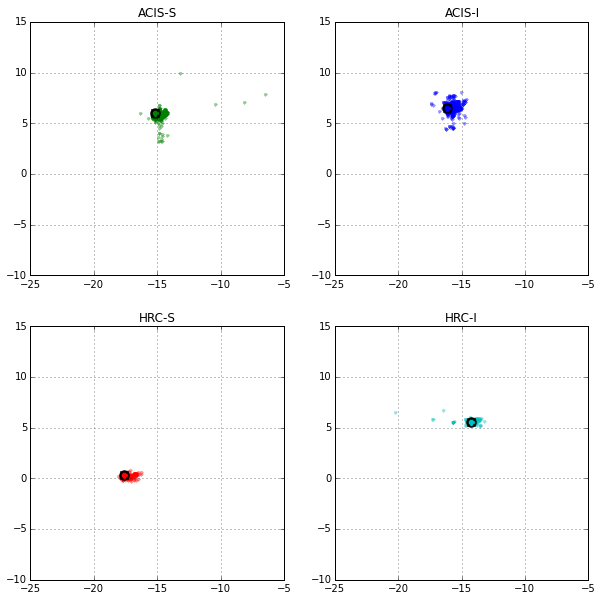

In [21]:
plt.figure(figsize=(10, 10))
from itertools import count
for color, det, i in zip('gbrc', detectors, count()):
    ok = obspars['detector'] == det
    op = obspars[ok]
    if len(op) > 5:
        plt.subplot(2, 2, i + 1)
        plt.plot(op['yag'], op['zag'], '.', color=color, alpha=0.4)
        plt.title(det)
        print(det, np.median(op['yag']), np.median(op['zag']))
        plt.xlim(-25, -5)
        plt.ylim(-10, 15)
        
for color, det, i in zip('gbrc', detectors, count()):
    plt.subplot(2, 2, i + 1)
    x, y = (val * 3600 for val in ra_dec_0[det])
    plt.plot(x, y, 'o', color='k', markersize=10)
    plt.plot(x, y, 'o', color=color, markersize=7)
    plt.grid()


In [22]:
obspars[:2]

obsid,ra_nom,dec_nom,roll_nom,ra_targ,dec_targ,detector,date_obs,y_det_offset,z_det_offset,sched_exp_time,yag,zag
int64,float64,float64,float64,float64,float64,string48,string152,float64,float64,float64,float64,float64
5390,345.685973578,55.2352279139,19.9628011747,345.682917,55.236389,ACIS-S,2006-03-23T00:16:02,0.1667,0.0,15000.0,-14.4721107639,6.07096489806
5409,293.671288478,30.5012652745,41.4144786205,293.688333,30.516361,ACIS-S,2006-02-13T16:30:58,1.5,0.0,86554.594,-14.4056027093,5.79083827902


In [23]:
def dmcoords_chipx_chipy(det, dy, dz, verbose=False):
    """
    Get the dmcoords-computed chipx and chipy for given detector and
    aspect solution DY and DZ values.  NOTE: the ``dy`` and ``dz`` inputs
    to dmcoords are flipped in sign from the ASOL values.  Generally the
    ASOL DY/DZ are positive and dmcoord input values are negative.  This
    sign flip is handled *here*, so input to this is ASOL DY/DZ.
    
    :param det: detector (ACIS-S, ACIS-I, HRC-S, HRC-I)
    :param dy: aspect solution DY value (mm)
    :param dz: aspect solution DZ value (mm)
    """
    # See the absolute_pointing_uncertainty notebook in this repo for the
    # detailed derivation of this -15.5, 6.0 arcsec offset factor.  See the
    # cell below for the summary version.
    ra0, dec0 = ra_dec_0[det]
    ciaorun('punlearn dmcoords')
    fpsys_map = {'HRC-I': 'HI1',
                'HRC-S': 'HS2',
                'ACIS-I': 'ACIS',
                'ACIS-S': 'ACIS'}
    cmd = dmcoords_cmd.format(ra=ra0, dec=dec0,
                              detector=(det if det.startswith('HRC') else 'ACIS'),
                              fpsys=fpsys_map[det], 
                              simx=sim_x_nom[det], simz=sim_z_nom[det],
                              dy=-dy, dz=-dz)
    ciaorun(cmd)
    if verbose:
        print(cmd)
    return [float(x) for x in ciaorun('pget dmcoords chipx chipy chip_id')]

In [24]:
def get_dy_dz(obsid):
    """
    Get statistical summary data for aspect solution DY/DZ for ``obsid``.
    
    :param obsid: ObsID
    :returns: min_dy, median_dy, max_dy, min_dz, median_dz, max_dz (mm)
    """
    asolfiles = asp_l1.get_files(obsid=obsid, content=['ASPSOL'])
    asol = Table.read(asolfiles[0])
    min_dy, median_dy, max_dy = (np.min(asol['dy']), 
                              np.median(asol['dy']),
                              np.max(asol['dy']))
    min_dz, median_dz, max_dz = (np.min(asol['dz']), 
                              np.median(asol['dz']),
                              np.max(asol['dz']))
    return min_dy, median_dy, max_dy, min_dz, median_dz, max_dz                                 

### Do some exploration / validation of methods

In [25]:
# What are CHIPX/Y for HRC-I at DY/Z = 0, 0
dmcoords_chipx_chipy('HRC-I', 0, 0)

[7635.786702004872, 7697.626779362401, 0.0]

#### Compare P. Zhao values to expected from dmcoords_chipx_chipy for ACIS-S and ACIS-I obsids

This is not incredibly independent since Zhao values also use dmcoords, but in a slightly different way.

In [26]:
dati['obsid', 'ap_chipx', 'ap_chipy'][:1]

obsid,ap_chipx,ap_chipy
float64,float64,float64
11613.0,933.95,997.64


In [27]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(11613)
dmcoords_chipx_chipy(det='ACIS-I', dy=median_dy, dz=median_dz)

[933.032449331515, 996.8262039124351, 3.0]

In [28]:
dats['obsid', 'ap_chipx', 'ap_chipy'][:1]

obsid,ap_chipx,ap_chipy
float64,float64,float64
12351.0,213.15,481.49


In [29]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(12351)
dmcoords_chipx_chipy(det='ACIS-S', dy=median_dy, dz=median_dz)

[213.9716784557346, 480.5748189717199, 7.0]

In [30]:
hrcs['obsid', 'ap_chipx', 'ap_chipy'][:1]

obsid,ap_chipx,ap_chipy
float64,float64,float64
10665.0,2096.82,8971.99


In [31]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(10665)
dmcoords_chipx_chipy(det='HRC-S', dy=median_dy, dz=median_dz, verbose=True)

dmcoords none asolfile=none detector="HRC-S" fpsys="HS2" opt=cel ra=-0.00490340990084 dec=8.60490150468e-05 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-1.52633993583 0 250.46603308" displace="0 -0.835084795952 -0.659420788288 0 0 0" verbose=0


[2095.356687376345, 8972.313037656517, 2.0]

In [32]:
hrci['obsid', 'ap_chipx', 'ap_chipy'][:1]

obsid,ap_chipx,ap_chipy
float64,float64,float64
10980.0,7615.44,7877.04


In [33]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(10980)
dmcoords_chipx_chipy(det='HRC-I', dy=median_dy, dz=median_dz, verbose=True)

dmcoords none asolfile=none detector="HRC-I" fpsys="HI1" opt=cel ra=-0.00396497249052 dec=0.00153249544158 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-1.03886635624 0 126.98297999" displace="0 -0.917803883553 -0.709993958473 0 0 0" verbose=0


[7612.931722189955, 7876.652332679578, 0.0]

### DY and DZ correspond to adding values to Y_A and Z_A

<img src="http://cxc.harvard.edu/proposer/POG/html/images/simc.png">

### Find DY/DZ values corresponding to each ACIS-I and HRC-S chip

In [34]:
# The third number of the output is the chip_id
dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=-10.0)

[341.1998798273522, 543.9560974505366, 1.0]

In [35]:
dmcoords_chipx_chipy(det='ACIS-I', dy=10.0, dz=10.0)

[471.8752066118261, 691.7321679345608, 2.0]

In [36]:
dmcoords_chipx_chipy(det='ACIS-I', dy=10.0, dz=-10.0)

[683.394489763009, 691.8310935709989, 0.0]

In [37]:
dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=10.0)

[553.3884100481896, 543.397829638697, 3.0]

In [38]:
dmcoords_chipx_chipy(det='HRC-S', dy=100, dz=0)

[2216.653716665205, 7941.835530668199, 3.0]

In [39]:
dmcoords_chipx_chipy(det='HRC-S', dy=-100, dz=0)

[2178.100292913261, 9742.43065221632, 1.0]

### Use Sherpa and dmcoords to empirically determine the transformation DY/Z to CHIPX/Y for each chip

In [40]:
def dyz_to_chipxy(pars, x):
    """
    Define a function to transform from DY/Z to CHIPX/Y
    CHIPX, CHIPY = c0 + cyz * [DY, DZ]  (dot product)
    """
    c0x, c0y, cyx, czx, cyy, czy = pars
    c0 = np.array([[c0x],
                   [c0y]])
    cyz = np.array([[cyx, czx],
                    [cyy, czy]])
    x = np.array(x).reshape(-1, 2).transpose()
    y = c0 + cyz.dot(x)
    return y.transpose().flatten()

In [41]:
pars = [971.91, 963.07, 0.0, +41.74, -41.74, 0.0]
x = [-1, -1, 0, -1, -1, -2.0]
# x = [-1, -1]
dyz_to_chipxy(pars, x)

array([  930.17,  1004.81,   930.17,   963.07,   888.43,  1004.81])

In [42]:
def fit_xform(det, chip_id, dy0, dz0):
    """
    Fit the transform model to 3 points forming an "L" on the chip around
    the ``dy0`` and ``dz0`` DY/Z values.
    
    :param det: detector (can be lower case)
    :param chip_id: numerical chip ID using dmcoord convention (ACIS=0 to 9, HRC=0 to 3)
    :param dy0: asol DY center value (mm)
    :param dz0: asol DZ center value (mm)
    
    :returns: sherpa fit_results() object
    """
    det = det.upper()
    x = []
    y = []
    for ddy, ddz in ((0, 0), (1, 0), (0, 1)):
        dy = dy0 + ddy
        dz = dz0 + ddz
        cx, cy, cid = dmcoords_chipx_chipy(det, dy, dz)
        if cid != chip_id:
            raise ValueError('Chip mismatch {} != {}'.format(cid, chip_id))
        x.extend([dy, dz])
        y.extend([cx, cy])
    ui.load_arrays(1, np.array(x), np.array(y))
    ui.load_user_model(dyz_to_chipxy, 'xform_mdl')
    ui.add_user_pars('xform_mdl', ['c0x', 'c0y', 'cyx', 'czx', 'cyy', 'czy'])
    ui.set_model(xform_mdl)
    ui.fit()
    
    return ui.get_fit_results()

In [43]:
fr = fit_xform('ACIS-I', 3, 0.0, 0.0)
fr.parvals

(970.79510723581086,
 961.857103766146,
 -0.0010063076019000662,
 -41.741676026373483,
 41.741541613023088,
 -0.10438579973210077)

In [44]:
fr = fit_xform(det='HRC-I', chip_id=0, dy0=0.0, dz0=0.0)
fr.parvals

(7635.7867020048716,
 7697.6267793624011,
 -109.98021295713716,
 109.98021295712397,
 109.98021295713215,
 109.98021295713033)

### Do the fitting for each chip on ACIS and HRC

In [45]:
det_ids = (('acis-i', 3, 0, 0),
          ('acis-i', 0, 10, -10),
          ('acis-i', 1, -10, -10),
          ('acis-i', 2, 10, 10),
          ('acis-s', 7, 0, 0),
          ('acis-s', 6, 25, 0),
          ('acis-s', 5, 50, 0),
          ('acis-s', 4, 75, 0),
          ('acis-s', 8, -25, 0),
          ('acis-s', 9, -50, 0),
          ('hrc-i', 0, 0, 0),
           ('hrc-s', 1, -100, 0),
          ('hrc-s', 2, 0, 0),
           ('hrc-s', 3, 100, 0),
          )

In [46]:
xforms = {}

In [47]:
for det, chip_id, dy0, dz0 in det_ids:
    key = det.upper(), chip_id
    if key in xforms:
        continue
    print(key)
    fr = fit_xform(det, chip_id, dy0, dz0)
    xforms[key] = fr.parvals

('ACIS-I', 3)
('ACIS-I', 0)
('ACIS-I', 1)
('ACIS-I', 2)
('ACIS-S', 7)
('ACIS-S', 6)
('ACIS-S', 5)
('ACIS-S', 4)
('ACIS-S', 8)
('ACIS-S', 9)
('HRC-I', 0)
('HRC-S', 1)
('HRC-S', 2)
('HRC-S', 3)


### Compare model prediction to actual

In [48]:
print(dyz_to_chipxy(xforms['ACIS-I', 1], [-10, -10]))
print(dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=-10.0))

[ 341.19987983  543.95609745]
[341.1998798273522, 543.9560974505366, 1.0]


In [49]:
print(dyz_to_chipxy(xforms['ACIS-S', 7], [0, 0]))
print(dmcoords_chipx_chipy(det='ACIS-S', dy=0.0, dz=0.0))

[ 251.60694446  519.81777554]
[251.6069444592493, 519.8177755439388, 7.0]


In [50]:
print(dyz_to_chipxy(xforms['HRC-I', 0], [0, 0]))
print(dmcoords_chipx_chipy(det='HRC-I', dy=0.0, dz=0.0))

[ 7635.786702    7697.62677936]
[7635.786702004872, 7697.626779362401, 0.0]


In [51]:
print(dyz_to_chipxy(xforms['HRC-S', 2], [0, 0]))
print(dmcoords_chipx_chipy(det='HRC-S', dy=0.0, dz=0.0))

[ 2197.75277632  8842.3062157 ]
[2197.752776317439, 8842.30621569804, 2.0]


### Make a nicer format to copy into chandra_aca.drift module

In [52]:
xforms_out = {}
for key, val in xforms.items():
    vals = [round(x, 3) for x in val]
    xforms_out[key] = {'c0': [vals[0], vals[1]],
                      'cyz': [[vals[2], vals[3]],
                              [vals[4], vals[5]]]}

In [53]:
from pprint import pprint
pprint(xforms_out)

{('ACIS-I', 0): {'c0': [1100.806, 1110.299],
                 'cyz': [[0.001, 41.742], [-41.742, 0.105]]},
 ('ACIS-I', 1): {'c0': [-76.208, 962.413],
                 'cyz': [[0.001, -41.742], [41.741, 0.104]]},
 ('ACIS-I', 2): {'c0': [54.468, 1110.197],
                 'cyz': [[-0.001, 41.742], [-41.742, -0.105]]},
 ('ACIS-I', 3): {'c0': [970.795, 961.857],
                 'cyz': [[-0.001, -41.742], [41.742, -0.104]]},
 ('ACIS-S', 4): {'c0': [3382.364, 520.024],
                 'cyz': [[-41.695, -0.021], [0.021, -41.689]]},
 ('ACIS-S', 5): {'c0': [2338.96, 519.15],
                 'cyz': [[-41.691, -0.031], [0.037, -41.689]]},
 ('ACIS-S', 6): {'c0': [1296.05, 519.532],
                 'cyz': [[-41.69, -0.031], [0.036, -41.689]]},
 ('ACIS-S', 7): {'c0': [251.607, 519.818],
                 'cyz': [[-41.689, -0.022], [0.022, -41.689]]},
 ('ACIS-S', 8): {'c0': [-790.204, 519.784],
                 'cyz': [[-41.69, -0.02], [0.02, -41.689]]},
 ('ACIS-S', 9): {'c0': [-1832.423, 519.546